In [1]:

import numpy as np 
import pandas as pd 

import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from itertools import compress

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\VI Pro\mbti_1.csv')

In [3]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
dist = df['type'].value_counts()
dist

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [5]:
dist.index

Index(['INFP', 'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'ENTJ',
       'ISTJ', 'ENFJ', 'ISFJ', 'ESTP', 'ESFP', 'ESFJ', 'ESTJ'],
      dtype='object')

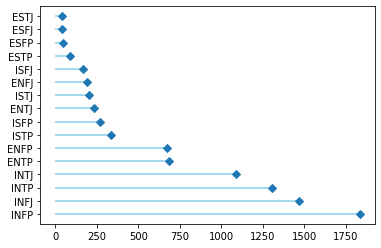

In [6]:
plt.hlines(y=list(range(16)), xmin=0, xmax=dist, color='skyblue')
plt.plot(dist, list(range(16)), "D")
# plt.stem(dist)
plt.yticks(list(range(16)), dist.index)
plt.show()

In [7]:
df['seperated_post'] = df['posts'].apply(lambda x: x.strip().split("|||"))
df['num_post'] = df['seperated_post'].apply(lambda x: len(x))
df.head()

,type,posts,seperated_post,num_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
1,ENTP,'I'm finding the lack of me in these posts ver...,['I'm finding the lack of me in these posts ve...,50
2,INTP,'Good one _____ https://www.youtube.com/wat...,['Good one _____ https://www.youtube.com/wa...,50
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","['Dear INTP, I enjoyed our conversation the ...",50
4,ENTJ,'You're fired.|||That's another silly misconce...,"['You're fired., That's another silly misconce...",50


In [8]:
df['seperated_post'][1]

["'I'm finding the lack of me in these posts very alarming.",
 "Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...",
 "Giving new meaning to 'Game' theory.",
 "Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.",
 'This + Lack of Balance and Hand Eye Coordination.',
 "Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...",
 "You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...",
 'http://img188.imageshack.us/img188/

In [9]:
df['id'] = df.index
df.head()

,type,posts,seperated_post,num_post,id
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50,0
1,ENTP,'I'm finding the lack of me in these posts ver...,['I'm finding the lack of me in these posts ve...,50,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,['Good one _____ https://www.youtube.com/wa...,50,2
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","['Dear INTP, I enjoyed our conversation the ...",50,3
4,ENTJ,'You're fired.|||That's another silly misconce...,"['You're fired., That's another silly misconce...",50,4


In [10]:
len(df)

8675

In [11]:
expanded_df = pd.DataFrame(df['seperated_post'].tolist(), index=df['id']).stack().reset_index(level=1, drop=True).reset_index(name='idposts')

In [12]:
expanded_df.head()

,id,idposts
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,0,enfp and intj moments https://www.youtube.com...
3,0,What has been the most life-changing experienc...
4,0,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


In [13]:
expanded_df=expanded_df.join(df.set_index('id'), on='id', how = 'left')

In [14]:
expanded_df=expanded_df.drop(columns=['posts','seperated_post','num_post'])

In [15]:
expanded_df.head()

,id,idposts,type
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw,INFJ
1,0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,INFJ
2,0,enfp and intj moments https://www.youtube.com...,INFJ
3,0,What has been the most life-changing experienc...,INFJ
4,0,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,INFJ


In [16]:
def clean_text(text):
    result = re.sub(r'http[^\s]*', '',text)
    result = re.sub('[0-9]+','', result).lower()
    result = re.sub('@[a-z0-9]+', 'user', result)
    return re.sub('[%s]*' % string.punctuation, '',result)

In [17]:
final_df = expanded_df.copy()

In [18]:
final_df['idposts'] = final_df['idposts'].apply(clean_text)

In [19]:
final_df.head()

,id,idposts,type
0,0,,INFJ
1,0,,INFJ
2,0,enfp and intj moments sportscenter not top ...,INFJ
3,0,what has been the most lifechanging experience...,INFJ
4,0,on repeat for most of today,INFJ


In [20]:
cleaned_df = final_df.groupby('id')['idposts'].apply(list).reset_index()

In [21]:
cleaned_df.head()

,id,idposts
0,0,"[, , enfp and intj moments sportscenter not..."
1,1,[im finding the lack of me in these posts very...
2,2,"[good one , of course to which i say i kno..."
3,3,[dear intp i enjoyed our conversation the ot...
4,4,"[youre fired, thats another silly misconceptio..."


In [22]:
df['clean_post'] = cleaned_df['idposts'].apply(lambda x: ' '.join(x))

In [23]:
df.head()

,type,posts,seperated_post,num_post,id,clean_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50,0,enfp and intj moments sportscenter not to...
1,ENTP,'I'm finding the lack of me in these posts ver...,['I'm finding the lack of me in these posts ve...,50,1,im finding the lack of me in these posts very ...
2,INTP,'Good one _____ https://www.youtube.com/wat...,['Good one _____ https://www.youtube.com/wa...,50,2,good one of course to which i say i know ...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","['Dear INTP, I enjoyed our conversation the ...",50,3,dear intp i enjoyed our conversation the oth...
4,ENTJ,'You're fired.|||That's another silly misconce...,"['You're fired., That's another silly misconce...",50,4,youre fired thats another silly misconception ...


In [24]:
vectorizer = CountVectorizer(stop_words = ['and','the','to','of',
                                           'infj','entp','intp','intj',
                                           'entj','enfj','infp','enfp',
                                           'isfp','istp','isfj','istj',
                                           'estp','esfp','estj','esfj',
                                           'infjs','entps','intps','intjs',
                                           'entjs','enfjs','infps','enfps',
                                           'isfps','istps','isfjs','istjs',
                                           'estps','esfps','estjs','esfjs'],
                            max_features=1500,
                            analyzer="word",
                            max_df=0.8,
                            min_df=0.1)

In [25]:
corpus = df['clean_post'].values.reshape(1,-1).tolist()[0]
vectorizer.fit(corpus)
X_cnt = vectorizer.fit_transform(corpus)

In [26]:
tfizer = TfidfTransformer()
tfizer.fit(X_cnt)
X = tfizer.fit_transform(X_cnt).toarray()

In [27]:
X.shape

(8675, 871)

In [28]:
all_words = vectorizer.get_feature_names()
n_words = len(all_words)

In [29]:
df['fav_world'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['info'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['decision'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['structure'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

In [30]:
df.head()

,type,posts,seperated_post,num_post,id,clean_post,fav_world,info,decision,structure
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50,0,enfp and intj moments sportscenter not to...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,['I'm finding the lack of me in these posts ve...,50,1,im finding the lack of me in these posts very ...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,['Good one _____ https://www.youtube.com/wa...,50,2,good one of course to which i say i know ...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","['Dear INTP, I enjoyed our conversation the ...",50,3,dear intp i enjoyed our conversation the oth...,0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,"['You're fired., That's another silly misconce...",50,4,youre fired thats another silly misconception ...,1,0,1,1


In [31]:
X_df = pd.DataFrame.from_dict({w: X[:, i] for i, w in enumerate(all_words)})

In [32]:
def sub_classifier(keyword):
    y_f = df[keyword].values
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_df, y_f, stratify=y_f)
    f_classifier = XGBClassifier()
    print(">>> Train classifier ... ")
    f_classifier.fit(X_f_train, y_f_train, 
                     early_stopping_rounds = 10, 
                     eval_metric="logloss", 
                     eval_set=[(X_f_test, y_f_test)], verbose=False)
    print(">>> Finish training")
    print("%s:" % keyword, sum(y_f)/len(y_f))
    print("Accuracy %s" % keyword, accuracy_score(y_f_test, f_classifier.predict(X_f_test)))
    print("AUC %s" % keyword, roc_auc_score(y_f_test, f_classifier.predict_proba(X_f_test)[:,1]))
    return f_classifier

In [33]:
fav_classifier = sub_classifier('fav_world')

>>> Train classifier ... 


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


>>> Finish training
fav_world: 0.2304322766570605
Accuracy fav_world 0.7584140156754264
AUC fav_world 0.6210365488316356


In [34]:
info_classifier = sub_classifier('info')

>>> Train classifier ... 


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


>>> Finish training
info: 0.13798270893371758
Accuracy info 0.8593822037805441
AUC info 0.6523956861552769


In [35]:
decision_classifier = sub_classifier('decision')

>>> Train classifier ... 


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


>>> Finish training
decision: 0.4589048991354467
Accuracy decision 0.7206085753803596
AUC decision 0.788873669882633


In [36]:
str_classifier = sub_classifier('structure')

>>> Train classifier ... 


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


>>> Finish training
structure: 0.395850144092219
Accuracy structure 0.6247118487782388
AUC structure 0.615007686907375


In [37]:
test_string = 'I like to observe, think, and analyze to find cons and pros. Based on my analysis, I like to create a solution based on cost effective analysis to maximize the resource to improve the performance. I like talking to my friends. I like to read and learn. I simulate a lot of different situations to see how I would react. I read or watch a lot to improve myself. I love talking to them and seeing what they have been up to. I have a variety of friends, and I appreciate they all experience different things. Listening to their emotion, experience, and life is always great.'.lower()
final_test = tfizer.transform(vectorizer.transform([test_string])).toarray()

In [38]:
test_point = pd.DataFrame.from_dict({w: final_test[:, i] for i, w in enumerate(all_words)})

In [39]:
pred = fav_classifier.predict_proba(test_point) #[I, E]
labels = ['I','E']
print(pred, labels[np.argmax(pred)])

[[0.83465314 0.16534688]] I


In [40]:
pred = info_classifier.predict_proba(test_point) #[N,S]
labels = ['N','S']
print(pred, labels[np.argmax(pred)])

[[0.6542915 0.3457085]] N


In [41]:
pred = decision_classifier.predict_proba(test_point) #[F, T]
labels = ['F','T']
print(pred, labels[np.argmax(pred)])

[[0.6702283 0.3297717]] F


In [42]:
pred = str_classifier.predict_proba(test_point) #[P, J]
labels = ['P','J']
print(pred, labels[np.argmax(pred)])

[[0.5569639  0.44303608]] P
